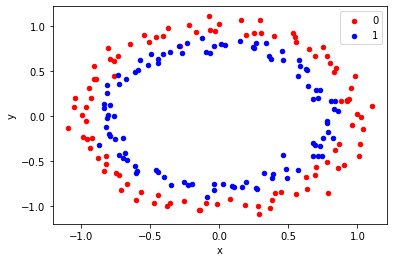

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=200, noise=0.05)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

input_dim = X_train.shape[1]
output_dim = 1

model = Sequential()
model.add(Dense(50, input_dim=input_dim))
model.add(Activation('linear'))
model.add(Dense(50))
model.add(Activation('linear'))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
model.fit(X_train, y_train, epochs=10)

prediction_prob = model.predict(X_test)
prediction_class = np.argmax(prediction_prob, axis=1)

print('Accuracy: ', accuracy_score(y_test, prediction_class))
print('AUC: ', roc_auc_score(y_test, prediction_prob))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
______________________________________________________

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

def nn_grid_search(parameter, n_folds, X_train, y_train):
    def nn_model(kernel, no_neurons, learning_rate, epochs, no_layers):
        model = Sequential()
        model.add(Dense(no_neurons, input_dim = X_train.shape[1]))
        model.add(Activation(kernel))
        for _ in range(0, no_layers):
            model.add(Dense(no_neurons))
            model.add(Activation(kernel))
            
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        
        return model
    
    grid_search = GridSearchCV(KerasClassifier(nn_model), parameters, cv=n_folds, scoring='roc_auc')
    
    grid_search.fit(X_train, y_train.ravel())
    
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_resutls_['params']
    
    return means, stds, params

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
parameters = {'no_neurons':[10,20], 'kernel':['relu','linear'], 'no_layers':[1,2], 'learning_rate':[0.1, 0.01, 0.001],'epochs':[5,10], 'verbose':[0]}
n_folds = 5

means, stds, params = nn_grid_search(parameters,n_folds,X_train,y_train)

print('Mean AUC (+/- standard deviation), for parameters')
for mean, std, param_o in zip(means, stds, params):
    print("%0.3f (+/- %0.03f) for %r"
          % (mean, std, param_o))